<a href="https://colab.research.google.com/github/Migaalee/Genomics_colab_HMI/blob/main/Illumina_vs_Nanopore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Project description

 Explanation of the dataset. Compare Illumina GT (L2 library), Control non-irradiated (L1 library) and Nanopore GT (barcode 65), Control non-irradiated (barcode 57)



### Install necessary software

In [66]:
!pip install pysam pandas seaborn graphkb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
pip install aplanat

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
pip install scikit-allel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
pip install --upgrade ipykernel


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Import all packages that will be used

In [70]:
# Numpy for data management
import numpy as np

# Pandas also for data management
import pandas as pd

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

#ScikitLearn

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import KFold

from sklearn.neighbors import KernelDensity

from sklearn.model_selection import StratifiedKFold

from sklearn.utils import shuffle

from sklearn.naive_bayes import GaussianNB

from sklearn.utils import shuffle

from scipy.stats import mode

from google.colab import files #this is to load files from your local disk

from sklearn.svm import LinearSVC

from sklearn.svm import SVC

from pysam import VariantFile

import itertools

from bokeh.layouts import gridplot
import aplanat
from aplanat import bars
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse.construct import hstack
import re
import allel


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-70-722a4d47e3d2>:52: DeprecationWarning: Please use `hstack` from the `scipy.sparse` namespace, the `scipy.sparse.construct` namespace is deprecated.
  from scipy.sparse.construct import hstack


### Auxiliary functions

In [259]:
def parse_vcf(fname, info_cols=None, nrows=None):
    """Parse a VCF file into a dataframe.
    The INFO column is parsed into a dictionary with specified dtype in distinct column.
    nrows: how many rows to read from the start of the header.
    Example:
    vcf_df_GT = parse_vcf('test.vcf', info_cols={'DP':int,'CIGAR':str,}, nrows=1000)
    """
    header = "CHROM POS ID REF ALT QUAL FILTER INFO FORMAT GT".split()
    vcf = pd.read_csv(
        fname, delimiter='\t', comment='#', names=header, nrows=nrows)
    # create a dictionary out of INFO field
    vcf['INFO'] = vcf['INFO'].str.split(";") \
        .apply(lambda x: dict([y.split("=") for y in x]))
    if info_cols is not None:
        for field, dtype in info_cols.items():
            try:
                vcf[field] = vcf['INFO'].apply(lambda x: x.get(field, None))
                vcf[field] = vcf[field].astype(dtype)
            except:
                pass
    return vcf

def parse_vcf2(fname, info_cols=None, nrows=None):
    """Parse a VCF file into a dataframe.
    The INFO column is parsed into a dictionary with specified dtype in distinct column.
    nrows: how many rows to read from the start of the header.
    Example:
    vcf_df_GT = parse_vcf('test.vcf', info_cols={'DP':int,'CIGAR':str,}, nrows=1000)
    """
    header = "CHROM POS ID REF ALT QUAL FILTER INFO FORMAT GT GT2".split()
    vcf = pd.read_csv(
        fname, delimiter='\t', comment='#', names=header, nrows=nrows)
    # create a dictionary out of INFO field
    vcf['INFO'] = vcf['INFO'].str.split(";") \
        .apply(lambda x: dict([y.split("=") for y in x]))
    if info_cols is not None:
        for field, dtype in info_cols.items():
            try:
                vcf[field] = vcf['INFO'].apply(lambda x: x.get(field, None))
                vcf[field] = vcf[field].astype(dtype)
            except:
                pass
    return vcf




def match_groudtruth (dataset, gt_dataset):
  """ Return dataset with ground truth data (1 for variant and 0 for false positive)
  based on the provided gt_dataset. Return dataset only with continous features. This function
  is to be used for creating dataset for training with ML classifiers.
 """
  dataset2=dataset.assign(GROUND=dataset.POS.isin(gt_dataset.POS).astype(int))
  dataset3= dataset2.loc[:,((dataset2.dtypes=='float64').values | (dataset2.dtypes=='int').values)]
  dataset4 = dataset3.set_index('POS')
  return dataset4


def confusion_matrix(dataset, gt_dataset, genome_size):
    """
    Based on the dataset that was generated from variant caller pipeline and ground truth dataset
    (all known mutations, e.g., all true positives) calculate the confusion matrix.
    """
    d_P = dataset["POS"].values
    g_P = gt_dataset["POS"].values
    matrix = np.zeros((2, 2))  # Matrix of 2 by 2 (added a missing closing parenthesis)
    matrix[1, 1] = genome_size - len(gt_dataset)  # True Negatives
    for i in d_P:
        if i in g_P:
            matrix[0, 0] += 1  # True Positives
        elif i not in g_P:
            matrix[0, 1] += 1  # False Positives
    for k in g_P:
        if k not in d_P:
            matrix[1, 0] += 1  # False Negatives
    return matrix




import matplotlib.pyplot as plt

def plot_custom_confusion_matrix(confusion_matrix, title="Confusion Matrix"):
    """
    This function plots a custom 2x2 confusion matrix with specified colors by name and labels for TP, TN, FP, FN.

    Args:
    confusion_matrix (list of lists): A 2x2 confusion matrix in the format [[TP, FP], [FN, TN]]
    title (str): Custom title for the confusion matrix (optional)

    Returns:
    None
    """
    class_names = ['Positive', 'Negative']

    plt.imshow(confusion_matrix, interpolation='nearest', cmap='gray', vmin=0, vmax=1, aspect='auto')  # Light gray background
    plt.title(title)  # Set the custom title

    tick_marks = [0, 1]
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    labels = ["TP", "FP", "FN", "TN"]
    for i in range(2):
        for j in range(2):
            if i == j:
                color = 'green'  # TP and TN in limegreen
            else:
                color = 'red'    # FP and FN in pink
            plt.text(j, i, str(confusion_matrix[i][j]), horizontalalignment="center", color=color)
            plt.text(j, i-0.2, labels[i*2+j], horizontalalignment="center")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Example usage with a custom title:
# Replace the example matrix with your actual 2x2 confusion matrix
# custom_matrix = [[42, 8], [12, 38]]
# plot_custom_confusion_matrix(custom_matrix, title="Confusion Matrix - My Title")




def metrics(matrix, calculate=None):
  """Function to calculate metrics for different variant callers based on confusion matrix.
  If no second argument is given, returns all the metrics. If particular metric is necessary,
  define the argument in the following way.
  Example:
  precision=metrics(matrix, "precision")
  """
  precision=matrix[0,0]/(matrix[0,0]+matrix[0,1])
  recall= matrix[0,0]/(matrix[0,0]+matrix[1,0])
  accuracy=(matrix[0,0]+matrix[1,1])/(matrix[0,0]+matrix[0,1]+matrix[1,0]+matrix[1,1])
  f1=2*(recall*precision)/(recall+precision)
  metrics=[precision, recall, accuracy, f1]
  if calculate is None:
    return metrics
  elif calculate == "precision":
    return precision
  elif calculate == "recall":
    return recall
  elif calculate == "accuracy":
    return accuracy
  elif calculate == "f1":
    return f1


def TPR_FPR(dataset, gt_dataset, genome_size): #pass dataframe from variant caller and GT dataframe
    d_P=dataset["POS"].values
    g_P=gt_dataset["POS"].values
    matrix=np.zeros((2,2)) # matrix of 2 by 2
    matrix[1,1]=genome_size - len(gt_dataset) # True Negatives
    for i in d_P:
        if i in g_P:
            matrix[0,0]+=1 #True Positives
        elif i not in g_P:
            matrix[0,1]+=1 #False Positives
    for k in g_P:
      if k not in d_P:
        matrix[1,0]=+1 #False Negatives
    TPR=matrix[0,0]/(matrix[0,0]+matrix[1,0])
    FPR=matrix[0,1]/(matrix[1,1]+matrix[0,1])
    return TPR, FPR



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Real variants

In [76]:
from google.colab import files
GT = files.upload()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving GT_83_Illumina_Nanopore.csv to GT_83_Illumina_Nanopore.csv


In [33]:
!ls


GT_83_Illumina_Nanopore.csv  sample_data


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [201]:
import io
vcf_df_GT = pd.read_csv(io.BytesIO(GT['GT_83_Illumina_Nanopore.csv']), sep=';')
vcf_df_GT

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,CHROM,POS,SEQ,REF_in_wMel,ALT_in_wMel,freq1,freq2,Unnamed: 7,RGS2_F4,REF,ALT,freq3,Barcode 65,REF.1,ALT.1,freq4
0,CP046924.1,10300,GGTCAATATT.TAAATAACAC,T,"G,N",3.468697,4.049844,NaN,NaN,812,89,10.960591,NaN,579,35,6.044905
1,CP046924.1,21801,ATTTGTCTAA.CATTGGTAGG,C,T,0.330396,0.367647,NaN,NaN,953,0,0.000000,NaN,1924,6,0.311850
2,CP046924.1,25451,GACTAGAATT.GGAATCTGTT,G,A,11.754685,10.648148,NaN,NaN,276,90,32.608696,NaN,227,48,21.145374
3,CP046924.1,26718,ACTTGGCTTT.GAGTATGCCA,G,A,12.142857,12.621359,NaN,NaN,381,132,34.645669,NaN,216,50,23.148148
4,CP046924.1,69121,TGGGGAACAG.ACCTTTTTAA,A,"G,N",11.903425,10.211095,NaN,NaN,9814,3178,32.382311,NaN,17735,5532,31.192557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,CP046924.1,1169393,ACACTTAAAG.CAAAAGGTCT,C,T,0.625000,0.455789,NaN,NaN,1150,18,1.565217,NaN,3087,36,1.166181
79,CP046924.1,1170910,AATATAAAGT.GATTTTCGAA,G,A,1.477833,1.260912,NaN,NaN,847,25,2.951594,NaN,2971,67,2.255133
80,CP046924.1,1201655,CATAGTGGTT.ATGCAATTTA,A,G,0.897480,0.888889,NaN,NaN,8104,146,1.801579,NaN,21145,318,1.503902
81,CP046924.1,1203393,TAGCGGAAAA.GTGCTTGAAA,G,"C,N",0.655308,0.742268,NaN,NaN,3868,49,1.266805,NaN,22950,307,1.337691


### Freebayes

Illumina

In [220]:
ILLUMINA_F=allel.read_vcf('Illumina_Freebayes_00075.vcf')
NANOPORE_F=allel.read_vcf('Nanopore_Freebayes_00075.vcf')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Nanopore

In [87]:
positions_Nanopore = NANOPORE_F['variants/POS']
positions_Nanopore

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 10022,  10025,  10031, ..., 398708, 398710, 398711], dtype=int32)

In [88]:

positions_Freebayes = ILLUMINA_F['variants/POS']
positions_Freebayes



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([  10068,   10079,   10082, ..., 1266577, 1266742, 1266775],
      dtype=int32)

In [89]:
print(len(positions_Freebayes))

10954


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
print(len(positions_Nanopore))

18163


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Parse using aux function

In [236]:
## define which columns to use for features
info_cols_all={'AB':int,'ABP':int, 'AC':int, 'AF':int , 'AN':int, 'AO':int,
               'CIGAR':str, 'DP':int , 'DPB':int, 'DPRA':int, 'EPP':int, 'EPPR':int, 'GTI':int, 'LEN':int, 'MEANALT':int, 'MQM':int,
               'MQMR':int, 'NS':int,'NUMALT':int, 'ODDS':int, 'PAIRED':int,'PAIREDR':int,'PAO':int, 'PQA':int, 'PQR':int, 'PRO':int, 'PRO':int, 'QA':int, 'QR':int , 'RO':int
               , 'RPL':int, 'RPP':int, 'RPPR':int, 'RUN':int, 'SAF':int, 'SAP':int, 'SAR':int, 'SRF':int, 'SRP':int, 'SRR':int}

info_cols_selected={'AO':int, 'DP':int , 'DPB':int, 'EPP':int, 'EPPR':int, 'MQM':int,
               'MQMR':int, 'ODDS':int, 'PAIRED':int,'PAIREDR':int, 'QA':int, 'QR':int , 'RO':int
               , 'RPL':int, 'RPP':int, 'RPPR':int, 'SAF':int, 'SAP':int, 'SAR':int, 'SRF':int, 'SRP':int, 'SRR':int}

info_cols_min={'DP':int}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [240]:


vcf_df_Ill_F = parse_vcf2('Illumina_Freebayes_00075.vcf', info_cols=info_cols_min, nrows=20000)

print(len(vcf_df_Ill_F))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10954


In [213]:
vcf_df_Nan_F = parse_vcf2('Nanopore_Freebayes_00075.vcf', info_cols=info_cols_min, nrows=20000)

print(len(vcf_df_Nan_F))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


18163


### Mutect individual

In [262]:
def parse_vcf_mutect(fname, info_cols=None, nrows=None):
    """Parse a VCF file into a dataframe.
    The INFO column is parsed into a dictionary with specified dtype in distinct column.
    nrows: how many rows to read from the start of the header.
    Example:
    vcf_df_GT = parse_vcf('test.vcf', info_cols={'DP': int, 'CIGAR': str}, nrows=1000)
    """
    header = "CHROM POS ID REF ALT QUAL FILTER INFO FORMAT GT".split()
    vcf = pd.read_csv(
        fname, delimiter='\t', comment='#', names=header, nrows=nrows)

    def parse_info(info_str):
        info_dict = {}
        for item in info_str.split(";"):
            parts = item.split("=")
            if len(parts) == 2:
                key, value = parts
            else:
                key = parts[0]
                value = ""
            info_dict[key] = value
        return info_dict

    vcf['INFO'] = vcf['INFO'].apply(parse_info)

    if info_cols is not None:
        for field, dtype in info_cols.items():
            try:
                vcf[field] = vcf['INFO'].apply(lambda x: x.get(field, None))
                vcf[field] = vcf[field].astype(dtype)
            except:
                pass
    return vcf


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [270]:
info_cols_min={'TLOD':int}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [273]:
vcf_df_Ill_M_L1 = parse_vcf_mutect('Illumina_Mutect_L1_S5.vcf', info_cols=None, nrows=20000)
vcf_df_Ill_M_L2 = parse_vcf_mutect('Illumina_Mutect_L2_S6.vcf', info_cols=None, nrows=20000)


#vcf_df_Ill_M

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [274]:
vcf_df_Ill_M_L1 = parse_vcf_mutect('Illumina_Mutect_L1_S5.vcf', info_cols=None, nrows=20000)
vcf_df_Ill_M_L2 = parse_vcf_mutect('Illumina_Mutect_L2_S6.vcf', info_cols=None, nrows=20000)
vcf_df_Nan_M_L57 = parse_vcf_mutect('Nanopore_Mutect_barcode57.vcf', info_cols=None, nrows=20000)
vcf_df_Nan_M_L65 = parse_vcf_mutect('Nanopore_Mutect_barcode65.vcf', info_cols=None, nrows=20000)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Mutect (cancer vs normal) pipeline (GT vs irradiated)

In [284]:
def parse_vcf_mutect2(fname, info_cols=None, nrows=None):
    """Parse a VCF file into a dataframe.
    The INFO column is parsed into a dictionary with specified dtype in distinct column.
    nrows: how many rows to read from the start of the header.
    Example:
    vcf_df_GT = parse_vcf('test.vcf', info_cols={'DP': int, 'CIGAR': str}, nrows=1000)
    """
    header = "CHROM POS ID REF ALT QUAL FILTER INFO FORMAT GT GT2".split()
    vcf = pd.read_csv(
        fname, delimiter='\t', comment='#', names=header, nrows=nrows)

    def parse_info(info_str):
        info_dict = {}
        for item in info_str.split(";"):
            parts = item.split("=")
            if len(parts) == 2:
                key, value = parts
            else:
                key = parts[0]
                value = ""
            info_dict[key] = value
        return info_dict

    vcf['INFO'] = vcf['INFO'].apply(parse_info)

    if info_cols is not None:
        for field, dtype in info_cols.items():
            try:
                vcf[field] = vcf['INFO'].apply(lambda x: x.get(field, None))
                vcf[field] = vcf[field].astype(dtype)
            except:
                pass
    return vcf


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [290]:
vcf_df_Ill_M_TN = parse_vcf_mutect('Illumina_Mutect_TN.vcf', info_cols=None, nrows=20000)
vcf_df_Nan_M_TN = parse_vcf_mutect('Nanopore_Mutect_TN.vcf', info_cols=None, nrows=20000)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Confusion matrix

In [221]:
test_confusion_Illumina_Freebayes=confusion_matrix(vcf_df_Ill_F, vcf_df_GT, genome_size=504933) #504933 is total amplicons that were designed
test_confusion_Illumina_Freebayes


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[6.3000e+01, 1.0891e+04],
       [2.0000e+01, 5.0485e+05]])

In [216]:
test_confusion_Nanopore_Freebayes=confusion_matrix(vcf_df_Nan_F, vcf_df_GT, genome_size=504933) #504933 is total amplicons that were designed
test_confusion_Nanopore_Freebayes


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[1.9000e+01, 1.8144e+04],
       [6.4000e+01, 5.0485e+05]])

In [292]:
test_confusion_Illumina_Mutect_L1=confusion_matrix(vcf_df_Ill_M_L1, vcf_df_GT, genome_size=504933) #504933 is total amplicons that were designed
#test_confusion_Illumina_Mutect_L1
test_confusion_Illumina_Mutect_L2=confusion_matrix(vcf_df_Ill_M_L2, vcf_df_GT, genome_size=504933) #504933 is total amplicons that were designed
#test_confusion_Illumina_Mutect_L2
test_confusion_Nanopore_Mutect_b57=confusion_matrix(vcf_df_Nan_M_L57, vcf_df_GT, genome_size=504933) #504933 is total amplicons that were designed
#test_confusion_Nanopore_Mutect_b57
test_confusion_Nanopore_Mutect_b65=confusion_matrix(vcf_df_Nan_M_L65, vcf_df_GT, genome_size=504933) #504933 is total amplicons that were designed
#test_confusion_Nanopore_Mutect_b65

test_confusion_Illumina_Mutect_TN=confusion_matrix(vcf_df_Ill_M_TN, vcf_df_GT, genome_size=504933) #504933 is total amplicons that were designed
test_confusion_Illumina_Mutect_TN

test_confusion_Nanopore_Mutect_TN=confusion_matrix(vcf_df_Nan_M_TN, vcf_df_GT, genome_size=504933) #504933 is total amplicons that were designed
test_confusion_Nanopore_Mutect_TN

#vcf_df_Ill_M_TN


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-259-bc945efb4095>:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if i in g_P:
<ipython-input-259-bc945efb4095>:71: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif i not in g_P:


array([[0.0000e+00, 5.9300e+02],
       [8.3000e+01, 5.0485e+05]])

### Plot confusion matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


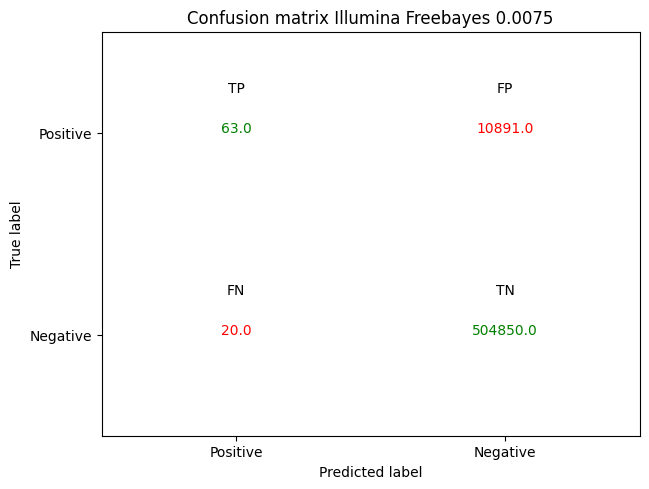

In [224]:
fig=plot_custom_confusion_matrix(test_confusion_Illumina_Freebayes, title="Confusion matrix Illumina Freebayes 0.0075")

fig


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


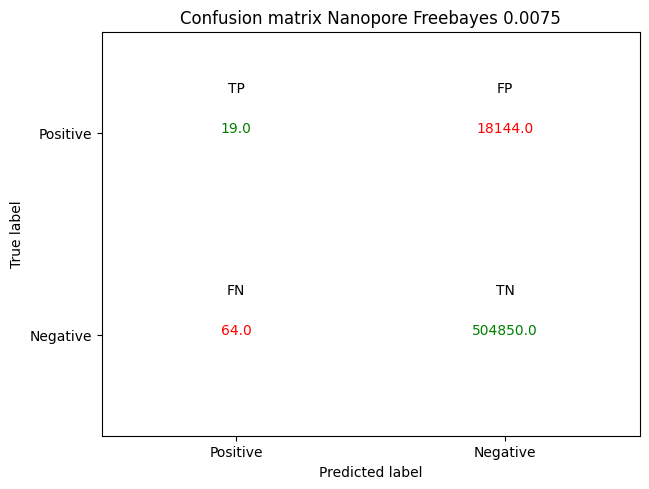

In [225]:
fig=plot_custom_confusion_matrix(test_confusion_Nanopore_Freebayes, title="Confusion matrix Nanopore Freebayes 0.0075")

fig


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


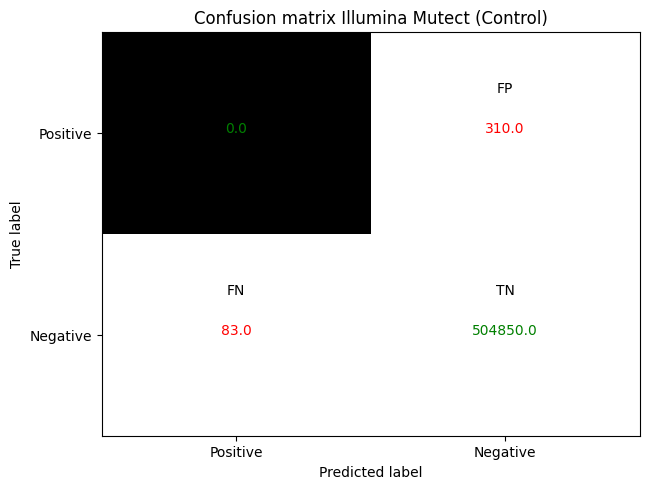

In [280]:
fig=plot_custom_confusion_matrix(test_confusion_Illumina_Mutect_L1, title="Confusion matrix Illumina Mutect (Control)")

fig

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


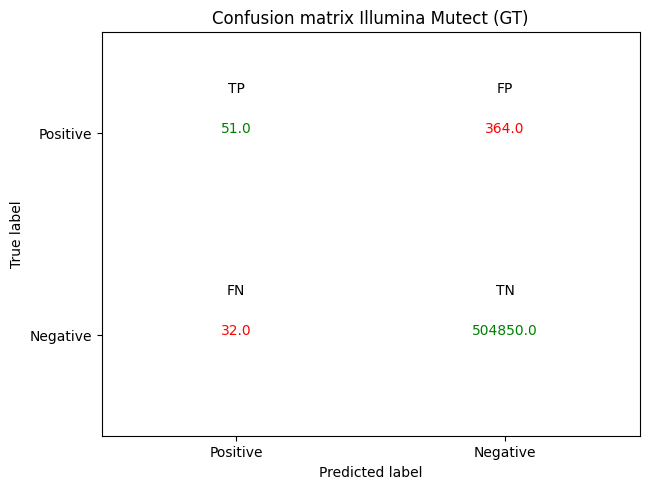

In [281]:
fig=plot_custom_confusion_matrix(test_confusion_Illumina_Mutect_L2, title="Confusion matrix Illumina Mutect (GT)")

fig

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


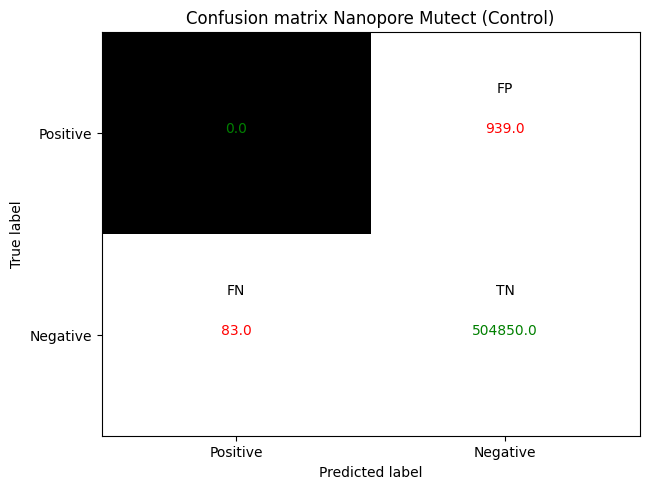

In [282]:
fig=plot_custom_confusion_matrix(test_confusion_Nanopore_Mutect_b57, title="Confusion matrix Nanopore Mutect (Control)")

fig

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


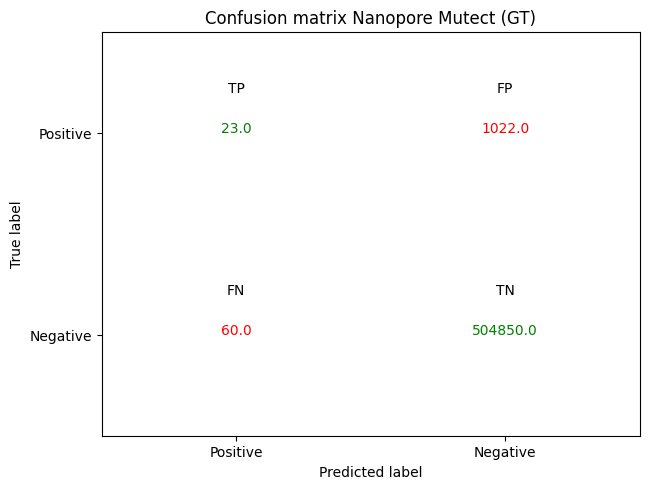

In [283]:
fig=plot_custom_confusion_matrix(test_confusion_Nanopore_Mutect_b65, title="Confusion matrix Nanopore Mutect (GT)")

fig

### Metrics

In [228]:
pr=metrics(test_confusion_Nanopore_Freebayes, "recall")
pr

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.2289156626506024

In [293]:
pr_rec_acc_f1=metrics(test_confusion_Nanopore_Freebayes)
pr_rec_acc_f1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.0010460826955899355,
 0.2289156626506024,
 0.9651905933543246,
 0.0020826482516715992]

In [294]:
pr_rec_acc_f1=metrics(test_confusion_Illumina_Freebayes)
pr_rec_acc_f1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.00575132371736352,
 0.7590361445783133,
 0.9788474363348739,
 0.011416145691764065]

In [295]:
pr_rec_acc_f1=metrics(test_confusion_Nanopore_Mutect_b65)
pr_rec_acc_f1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.02200956937799043,
 0.27710843373493976,
 0.9978614698935676,
 0.04078014184397163]

In [296]:
pr_rec_acc_f1=metrics(test_confusion_Nanopore_Mutect_b57)
pr_rec_acc_f1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-259-bc945efb4095>:136: RuntimeWarning: invalid value encountered in double_scalars
  f1=2*(recall*precision)/(recall+precision)


[0.0, 0.0, 0.9979797260967201, nan]

True Positive Rate and False Positive Rate

In [230]:
TPR_if,FPR_if =TPR_FPR(vcf_df_Ill_F, vcf_df_GT, genome_size=504933)
TPR_if, FPR_if


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.984375, 0.02111718866640426)

In [231]:
TPR_nf,FPR_nf =TPR_FPR(vcf_df_Nan_F, vcf_df_GT, genome_size=504933)
TPR_nf, FPR_nf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.95, 0.03469255861443917)